In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #not used
from scipy import signal
import pywt



**1. Data download and preprocessing**

1.1 Data cleaning and understanding

Reading the EEG data from the provided four electrodes by running the file collected during the long blink session equally long (510 points pro session). Conduct the preliminary data processing and visualization steps to gain some insight from the EEG recording:
- Splits and clean the data
- Selects the first 510 points for visualization

Clarifying the following questions with the professors

1. Are the amplitude value measure as microvolt? This information was not given
2. Are the index time series? If yes issit in seconds or milliseconds? Sampling frequency is 215 Hz at 2 seconds
3. What does 510 points pro session mean? It is an arbitrary decision from the data manager
4. Do we need more information about the four electrodes? No further knowledge is required

1.2 Load data, and parsing it from string to appropriate data type. Then, select the first 510 points for visualization.

In [ ]:
# Long blink data
df1 = pd.read_csv('data\\LongBlink.csv', sep = ",")
df1[['Col1', 'Col2', 'Col3', 'Col4']] = df1['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df1.drop(columns=['data'], inplace=True)
df1.head(5)
lb_ser1 = df1.iloc[:,0].str.strip('[').astype(float) #to remove square brackets and convert to float
lb_ser2 = df1.iloc[:,1].astype(float) #convert to float
lb_ser3 = df1.iloc[:,2].astype(float) #convert to float
lb_ser4 = df1.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
# ser 1,2,3,4 are numpy arrays, length: 25500, dtype: float64
df1 = pd.concat([lb_ser1, lb_ser2, lb_ser3, lb_ser4], axis=1) #concatenate the columns
df1.columns = ['lb_ser1', 'lb_ser2', 'lb_ser3', 'lb_ser4'] #rename the columns
# Extract the first 510 points of the data as sample and visualize it
df1_sample = df1.iloc[510:1020] 
df1_sample.plot.line(subplots=True, figsize=(20, 20))
plt.xlabel('No. of points')
plt.ylabel('Amplitude')
plt.title('The first 510 points of Long Blink')
#print(lb_ser1[0])

**1. Data download and preprocessing**

1.3 Data format compatibility
In this step, the MNE-Python package is used for analysis. MNE is an open source tool for exploring, visualizing, and analyzing human neurophysiological data, such as EEG. Firstly, a .fif file needs to be generated from csv to fit the raw data format used in this package for analysis.

1.4 Scaling the value 

"A healthy human EEG displays a certain pattern of activity correlate with how awake a person is. The range of frequencies observed are between 1 and 30 Hz, with amplitudes vary between 20 and 100 μV". However, the raw signals of the four electrodes provided exhibit different magnitude range, ("500 - 1100" or "400 - 1200"). 

The objective here is to standardize the magnitude of the variations in the raw signale from the four electrodes into a consistent range between 20 and 100 μV. Standardizing the range helps to achieve consistent and comparable magnitudes across the electrodes. Additionally, scaled data of similar amplitudes can lead to better convergence and efficient training for machine learning. 

Here, min max scaling is applied to rescale the raw signal values to the desired range between 20 and 100 μV. 

***Glossary***
μV : symbol for microvolts

***Source***
- https://en.wikipedia.org/wiki/Electroencephalography#:~:text=A%20healthy%20human%20EEG%20will,between%2020%20and%20100%20%CE%BCV 

***source code reference***

-  https://colab.research.google.com/drive/1ro2XBhpUKIlV5JCytetKoNFrVOCgdLAP?usp=sharingLink#scrollTo=T4VzMOJKSXlz
-  https://mne.tools/dev/auto_tutorials/preprocessing/10_preprocessing_overview.html



In [ ]:
import mne
from sklearn.preprocessing import MinMaxScaler

n_channels = len(df1.columns) #define number of channels
print(n_channels)
ch_names = list(df1.columns) #list of channel names
print(ch_names)

#Min-max scaling
scaler = MinMaxScaler(feature_range=(0.000020,0.000100))
df_scaled = scaler.fit_transform(df1.to_numpy()) 
df1_norm = pd.DataFrame(df_scaled, columns=df1.columns)

values = df1_norm.T # transpose the dataframe
ch_types = ['eeg']*df1.shape[1]
sampling_freq = 215 

info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)
raw_lb = mne.io.RawArray(values, info)

raw_lb.save('.\\data\\raw_lb.fif', overwrite=True)
print(values)

**1. Data download and preprocessing**

1.5 Artifact detection

MNE-Python includes tools for automated detection of certain artifacts such as blinks; one can always visually inspect the data to identify and annotate artifacts as well. Before looking at artifacts, SSP projectors is set aside in a separate variable and then remove them from raw object using del_proj() method so that the data can be inspected in its original, raw state. Signal-space projection (SSP) is a technique for removing noise from EEG signals by projecting the signal onto a lower-dimensional subspace. 

In [ ]:
ssp_projectors = raw_lb.info['projs'] 
raw_lb.del_proj() #use to remove SSP projection vector

**1. Data download and preprocessing**

1.6 Apply low-frequency drifts

Low-frequency drifts are most readlily detected by visual inspection using the basic plot() method, it is helpful to plot a relatively long time spac and to disable channel-wise DC shift correction. Here, 2 seconds is plotted. 

It is observed that there are approximately 12 pulses occuring every 0.25 seconds. This pattern results in around 50 pulses per second, corresponding to a frequency of 50 Hertz.

Given this observation, it is planned to apply a notch filter later, which is commonly use to eliminate specific inteferences frequences such as power line noise. The goal is to mitigate pertubations caused by unwanted frequency in the data. 

In [ ]:
eeg_channel = mne.pick_types(raw_lb.info, eeg=True) 
raw_lb.plot(duration=2, order=eeg_channel, remove_dc=True, scalings=dict(eeg=50e-6)) 


In [ ]:
# #PSD (power spectral density) provides information about the distribution of power across different frequencies in the EEG signal.
# raw_lb.plot_psd(tmin=0, tmax=50, fmin=0, fmax=107.5, average=True) 

In [ ]:
#raw_lb.compute_psd().plot(average=True, picks="data", exclude="bads").show()

**1. Data download and preprocessing**

1.7 Filtering EEG data
 
Before commence the filter process, the preprocessed raw data is converted to a DataFrame.

Filtering is the process of removing unwanted frequencies such as noise and artifacts from a signal and preserve the desired frequencies to extract relevant information. 

The filters used during preprocessing are third-order:
* median filter
* low pass filter
* high pass filter
* notch filter

Firstly, a segment of the data is defined, followed by the application of third-order median filter to remove the background noise. Subsequent processing involved additional filtering steps using both low-pass and high-pass filters. The Butterworth filter with a fifth-order design is employed, configuring cutoff frequencies at 0.5 Hertz for the low-pass filter and 50 Hertz for the high-pass filter. The Butterworth filter is known for maintaining a flat frequency response in the passband. To address power interference at 50 Hertz, a notch filter was then applied.

In the final step, a finite impulse response (FIR) filter was designed using the "signal.firwin" function from the SciPy library. This type of digital filter, widely used for signal processing tasks such as EEG signal filtering, was configured with 430 taps (coefficients). The cutoff frequencies for this FIR filter were set in the range of 0.01 to 0.06. 

***Source***

- https://neuraldatascience.io/7-eeg/erp_filtering.html

***Source code***

- https://www.kaggle.com/code/sam1o1/eeg-signal-processing
- https://www.daanmichiels.com/blog/2017/10/filtering-eeg-signals-using-scipy/



In [ ]:
# get pandas dataframe from raw format
data_lb = raw_lb.to_data_frame()
data_lb = data_lb.drop("time", axis=1) #drop "time" column

#get pandas series to use in data preprocessing
lb_ser1 = data_lb["lb_ser1"]
lb_ser3 = data_lb["lb_ser3"]
lb_ser4 = data_lb["lb_ser4"]
lb_ser2 = data_lb["lb_ser2"]

print(type(lb_ser1))
data_lb

In [ ]:
# Define the slice to display in the following code. Just change the value of 'SLICE_FROM' with 0 or a multiple of 510.
SLICE_FROM = 510
SLICE_TO = SLICE_FROM + 510

# Create the median filter function
def median(data: pd.Series | np.ndarray) -> np.ndarray:# pass either one, input: numpy array 1D (one column)
    #applying the median filter
    med_filtered= signal.medfilt(data, kernel_size=3) # applying the median filter order 3 (kernel_size=3)
    return med_filtered # return the med-filtered signal: numpy array 1D

# Create a butterworth bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5) -> tuple:
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data: pd.Series, lowcut: float, highcut: float, fs: float, order=5) -> np.ndarray:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# Create notch filter function at 50Hz
def notch_filter(time, band, freq, ripple, order, filter_type, data) -> np.ndarray:

    fs   = 1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = signal.iirfilter(
            order, 
            [low, high], 
            rp=ripple, 
            btype='bandstop',
            analog=False, 
            ftype=filter_type
        )
    
    a = signal.lfilter(b, a, data)
    return a

In [ ]:
# Create a preprocessing function

def preprocessing(data: pd.DataFrame, slice_from: int, slice_to: int) -> pd.DataFrame:
    # Define butter bandpass filter parameters
    lowcut = 0.5
    highcut = 40
    fs = 215
    order = 4
    
    # Define notch filter parameters
    time = 1/215
    band = 4
    freq = 50
    ripple = 1
    order = 2
    filter_type = 'butter'

    # Create an empty pandas DataFrame
    cleaned_data = pd.DataFrame()

    # Loop through all columns and apply the filters
    for key, value in data.items():

        # for each column plot all the filters results
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(15,25)) # 4 rows, 1 column

        # apply median filter
        series_mf = median(value)

        # apply butter bandpass filter
        series_bbf = butter_bandpass_filter(series_mf, lowcut, highcut, fs, order)

        # apply notch filter
        series_nf = notch_filter(time, band, freq, ripple, order, filter_type, series_bbf)

        # add the processed data to the dataframe
        cleaned_data[key] = series_nf

        # plot each steps ax0 raw value, ax1 after butter bandpass, ax2 after median, ax3 after notch filter.
        ax0.plot(value[slice_from:slice_to])
        ax0.set_title('Raw data')
        ax0.set_xlabel('Data Point')
        ax0.set_ylabel('Amplitude (\u03BCV)')

        ax1.plot(series_mf[slice_from:slice_to], color="orange")
        ax1.set_title('After median filter')
        ax1.set_xlabel('Data Point')
        ax1.set_ylabel('Amplitude (\u03BCV)')

        ax2.plot(series_bbf[slice_from:slice_to], color="red")
        ax2.set_title('+ butter bandpass filter')
        ax2.set_xlabel('Data Point')
        ax2.set_ylabel('Amplitude (\u03BCV)')


        ax3.plot(series_nf[slice_from:slice_to], color="green")
        ax3.set_title('+ notch filter')
        ax3.set_xlabel('Data Point')
        ax3.set_ylabel('Amplitude (\u03BCV)')

        
        fig.suptitle(f"Filters apply to '{key}'")

    return cleaned_data

In [ ]:
lb_cleaned = preprocessing(data_lb, SLICE_FROM, SLICE_TO)
print(lb_cleaned)


In [ ]:
# Create a FIR filter function
cutoff_freq = [0.01, 0.06] #Hz
filter = signal.firwin(430, [0.01, 0.06], pass_zero=False)

# Visualize the filter
# plt.figure(figsize=(12, 6))
# plt.plot(filter)
# plt.title("Filtered EEG Data")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# Create a comparison plot function
def plot_compare(
        df_original: np.ndarray | pd.DataFrame, 
        df_cleaned: np.ndarray | pd.DataFrame,
        slice_from: int, 
        slice_to: int, 
        color_original: str="green", 
        color_cleaned: str="orange",
        name: str=""
) -> None: #return nothing because its a plot function
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
    ax1.plot(df_original[slice_from:slice_to], color_original)
    ax2.plot(df_cleaned[slice_from:slice_to], color_cleaned)
    fig.suptitle(f"Signal Before and after FIRWIN function \n {name}")

In [ ]:
# Create a function to apply the filter
def processing_fir_filter(df: pd.DataFrame, filter_function: signal.filter_design) -> pd.DataFrame:
    filtered_data = pd.DataFrame()
    for key, value in df.items():
        processed_data = signal.convolve(value, filter_function, mode='same')

        # plot results
        plot_compare(df[key], processed_data, SLICE_FROM, SLICE_TO, name=f"{key}")
        # add the processed data to the dataframe
        filtered_data[key] = processed_data

    return filtered_data

In [ ]:
# Apply signal.firwin function : FIR (finite impulse response) filter to process the signal in series 1 and compare the results
lb_filtered = processing_fir_filter(lb_cleaned, filter)

**Run the same on short blink data**

Text(0.5, 1.0, 'The first 510 points of Short Blink')

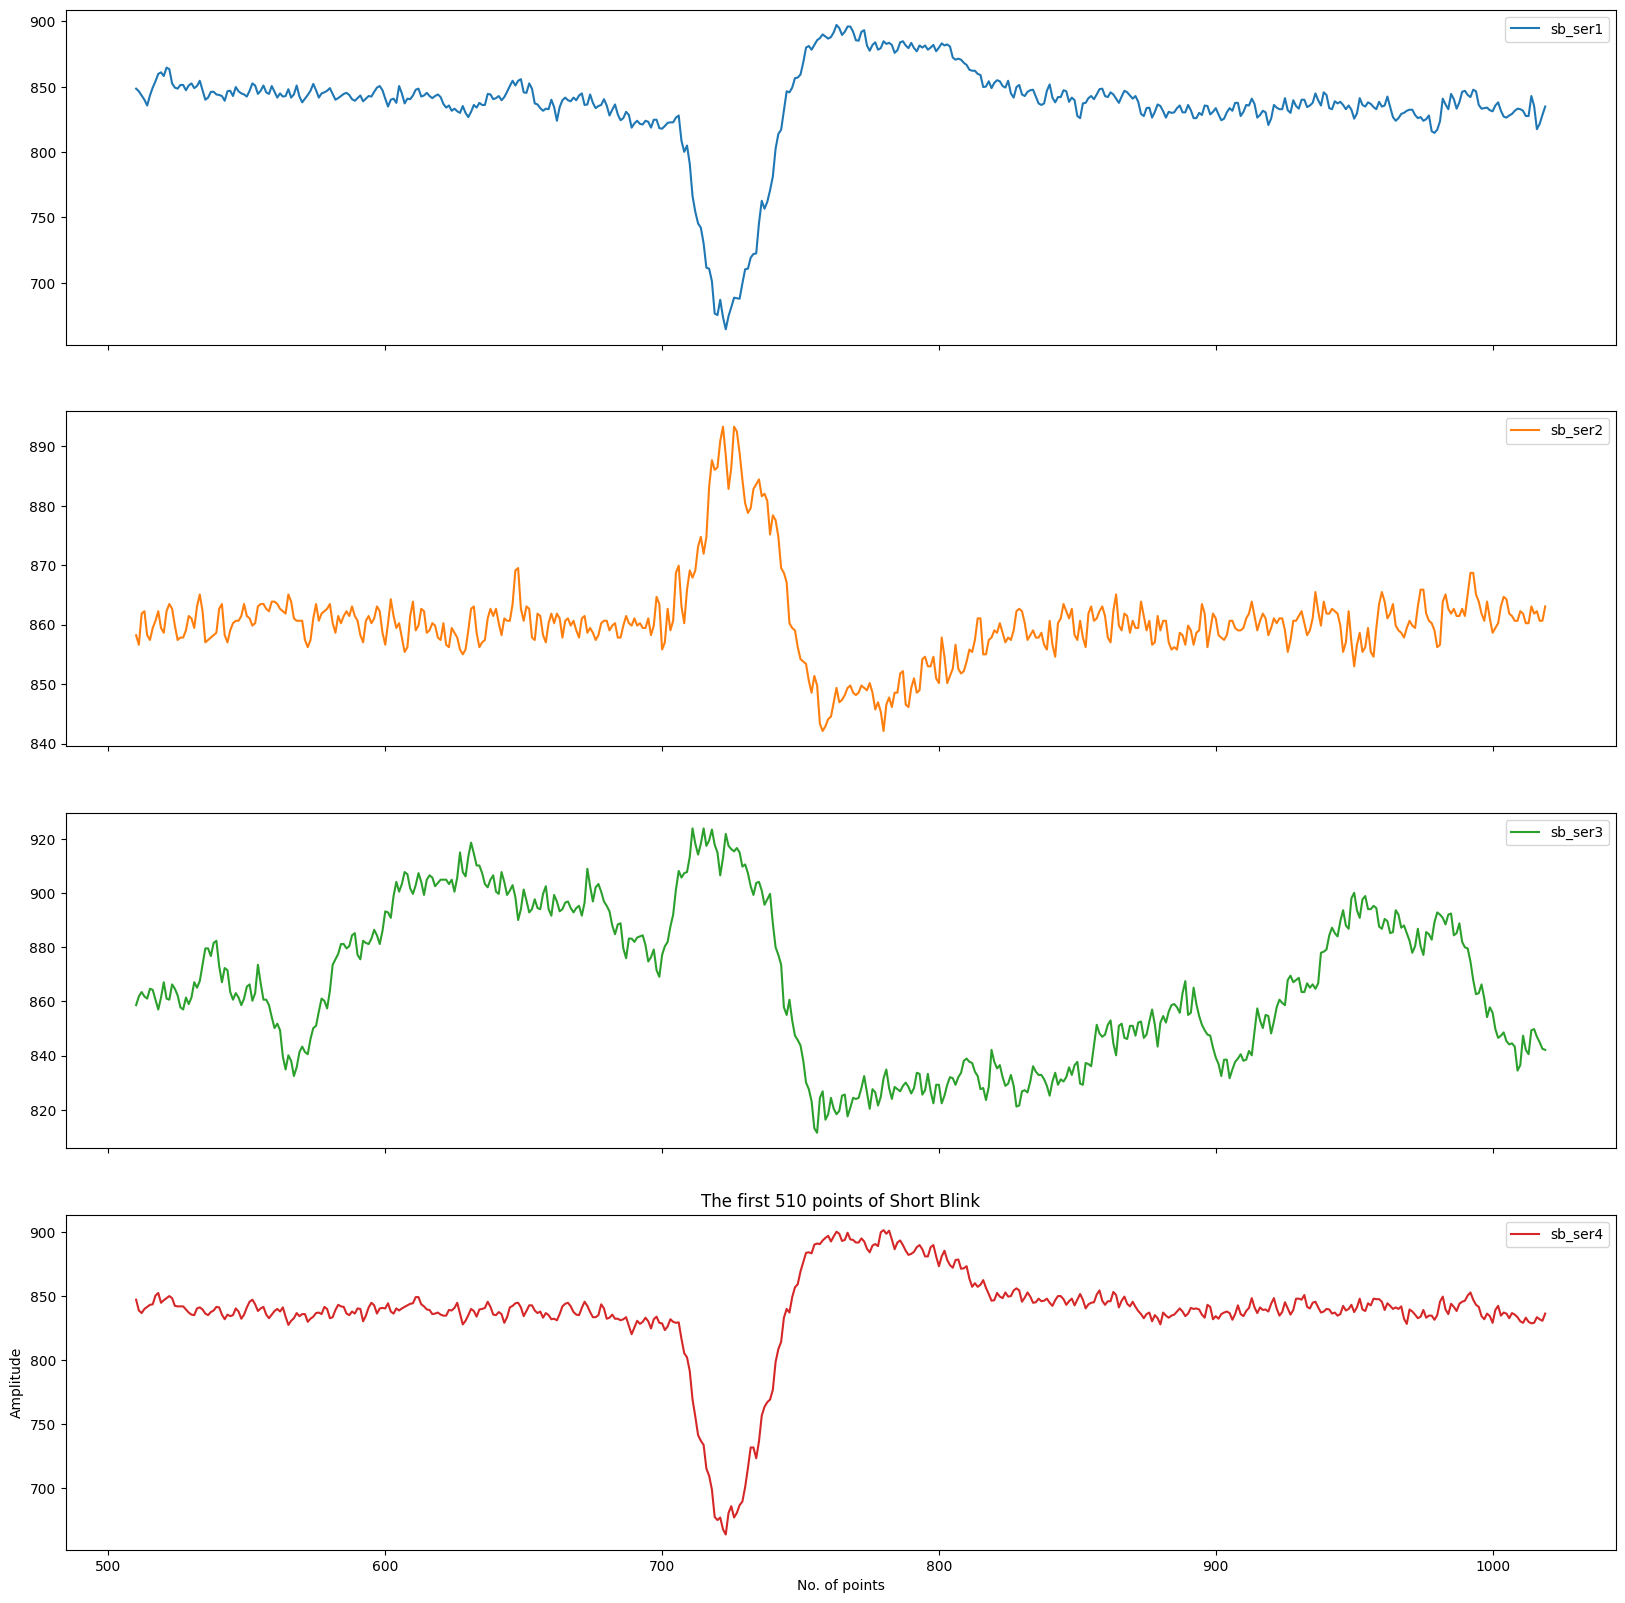

In [99]:
# Short blink data
df2 = pd.read_csv('data\\ShortBlink.csv', sep = ",")
df2[['Col1', 'Col2', 'Col3', 'Col4']] = df2['data'].str.split(',', expand=True)
# Remove the original 'HeaderColumn' column
df2.drop(columns=['data'], inplace=True)
df2.head(5)
sb_ser1 = df2.iloc[:,0].str.strip('[').astype(float) #to remove square brackets and convert to float
sb_ser2 = df2.iloc[:,1].astype(float) #convert to float
sb_ser3 = df2.iloc[:,2].astype(float) #convert to float
sb_ser4 = df2.iloc[:,3].str.strip(']').astype(float) #remove square brackets and convert to float
# ser 1,2,3,4 are numpy arrays, length: 25500, dtype: float64
df2 = pd.concat([sb_ser1, sb_ser2, sb_ser3, sb_ser4], axis=1) #concatenate the columns
df2.columns = ['sb_ser1', 'sb_ser2', 'sb_ser3', 'sb_ser4'] #rename the columns
# Extract the first 510 points of the data as sample and visualize it
df2_sample = df2.iloc[510:1020] 
df2_sample.plot.line(subplots=True, figsize=(20, 20))
plt.xlabel('No. of points')
plt.ylabel('Amplitude')
plt.title('The first 510 points of Short Blink')
#print(sb_ser1[0])

In [ ]:
import mne
from sklearn.preprocessing import MinMaxScaler

n_channels = len(df2.columns) #define number of channels
print(n_channels)
ch_names = list(df2.columns) #list of channel names
print(ch_names)

# Min-max scaling
scaler = MinMaxScaler(feature_range=(0.000020,0.000100))
df2_scaled = scaler.fit_transform(df2.to_numpy()) 
df2_norm = pd.DataFrame(df2_scaled, columns=df2.columns)

values = df2_norm.T # transpose the dataframe
ch_types = ['eeg']*df2.shape[1]
sampling_freq = 215 

info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)
raw_sb = mne.io.RawArray(values, info)

raw_sb.save('.\\data\\raw_sb.fif', overwrite=True)
print(values)

In [ ]:
ssp_projectors = raw_sb.info['projs'] 
raw_sb.del_proj() #use to remove SSP projection vector
eeg_channel = mne.pick_types(raw_sb.info, eeg=True) 
raw_sb.plot(duration=2, order=eeg_channel, remove_dc=True, scalings=dict(eeg=50e-6)) 


In [ ]:
# Get pandas dataframe from raw format
data_sb = raw_sb.to_data_frame()
data_sb = data_sb.drop("time", axis=1) #drop "time" column

# Get pandas series to use in data preprocessing
sb_ser1 = data_sb["sb_ser1"]
sb_ser3 = data_sb["sb_ser3"]
sb_ser4 = data_sb["sb_ser4"]
sb_ser2 = data_sb["sb_ser2"]

print(type(sb_ser1))
data_sb

In [ ]:
sb_cleaned = preprocessing(data_sb, SLICE_FROM, SLICE_TO)
print(sb_cleaned)


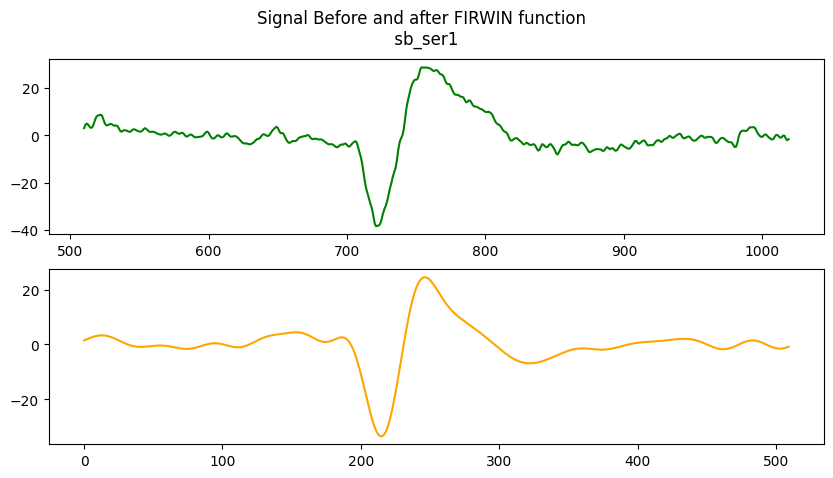

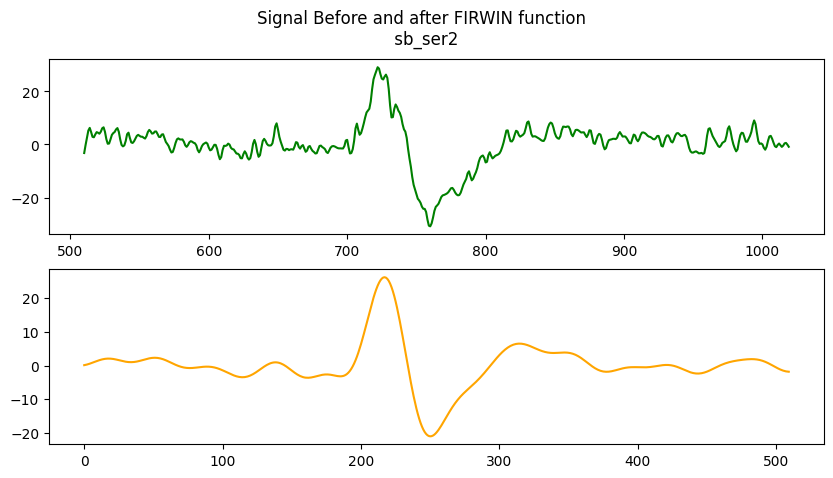

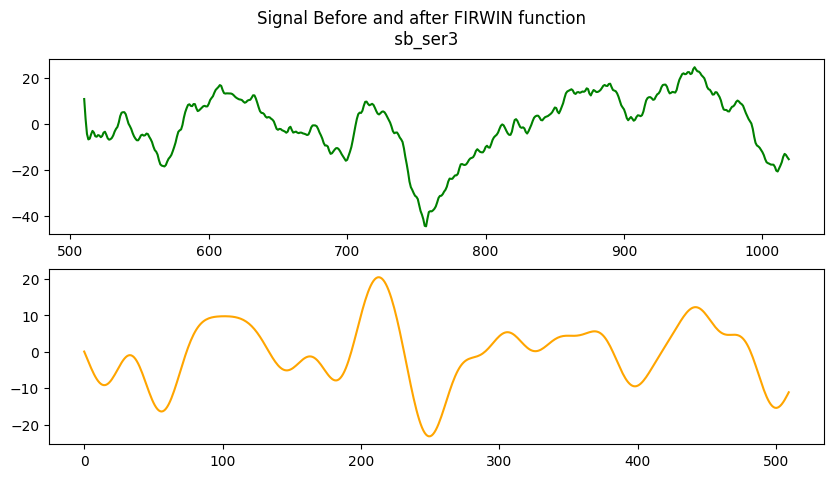

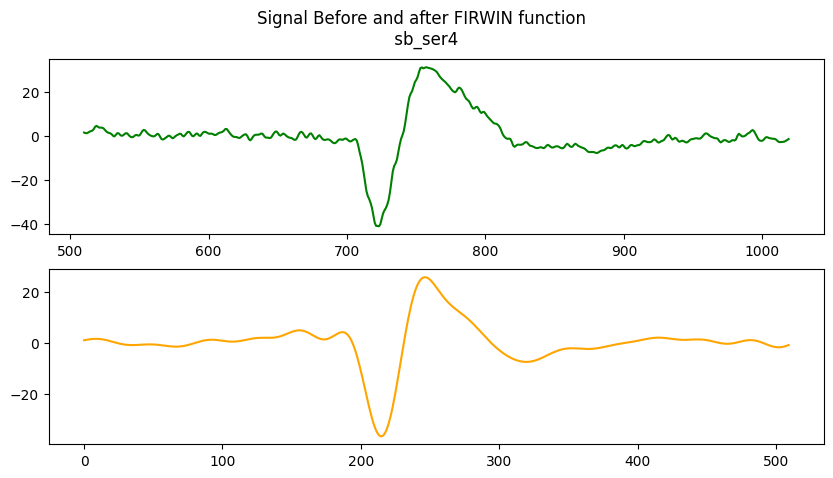

In [104]:
sb_filtered = processing_fir_filter(sb_cleaned, filter)

**Wavelet Decomposition**

In [ ]:
import pywt
# Wavelet decomposition
wavelet = 'db1'  # Choose a wavelet (Daubechies wavelet of order 1 in this case)
level = 4  # Number of decomposition levels
signal = data_lb.iloc[:,0]  # Signal to be decomposed

coeffs = pywt.wavedec(signal, wavelet, level=level)

# Plot the original signal and its wavelet coefficients
plt.figure(figsize=(12, 6))
plt.subplot(level + 2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')

for i in range(level):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(coeffs[i])
    plt.title(f'Level {i + 1} Coefficients')

plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[level])
plt.title(f'Approximation Coefficients (Level {level})')

plt.tight_layout()
plt.show()

In [ ]:
time_list=[]
for i in range (1,6):
    time=(time_sig_dic[Raw_data_paths[i][-15:-4]].index.values[-1])
    time_list.append(time)
data=np.array(time_list)
time_length=pd.DataFrame(data=data,columns=['Signl length'])
time_length

**Windowing**

(Rephrase) After filtering the signals, the clean signals were segmented using a sliding window. The process involved some steps. First, a 4-second width window was used to loop through the time-domain signal dividing it into small segments for 4 seconds each. The window width was decided based on the literature done. To decide whether the sliding window has to be overlapping or non-overlapping, both methods were tried. The result was that the overlapping method was more efficient and resulted in higher accuracy. We started with a 50% overlap.

Then, we tried different values until the highest accuracy was achieved at a 4-second sliding window and 3-second overlap. The segments after that were converted from the time-domain to the frequency-domain using the Fast Fourier transform. In addition to that, the signals were obtained in the time-frequency domain as stated in the features extracted in the time-frequency domain result in getting a higher classification accuracy. The Wavelet transformation was used in converting the signals to the time-frequency domain.

In [ ]:
#Independent Component Analysis (ICA) for artifact removal
